<a href="https://colab.research.google.com/github/Dongjin-1203/Study-code/blob/main/NLP_%EC%8B%A4%EC%8A%B5(IMDB)_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP 실습: 영화 리뷰 감정분석(IMDB)

인터넷 영화 데이터베이스(Internet Movie Database)로부터 가져온 양극단의 리뷰 5만 개로 이루어진 IMDB 데이터셋을 사용하겠습니다.2 이 데이터셋은 훈련 데이터 2만 5,000개와 테스트 데이터 2만 5,000개로 나뉘어 있고 각각 50%는 부정, 50%는 긍정 리뷰로 구성되어 있습니다.
출처: https://thebook.io/080315/0182/

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [3]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False

# 데이터 불러오기

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [5]:
# IMDB 데이터 다운로드
from datasets import load_dataset
imdb = load_dataset("imdb")

In [6]:
# DataFrame으로 변환
train_df = pd.DataFrame(imdb['train'])
test_df = pd.DataFrame(imdb['test'])

In [7]:
train_df.head()

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0


# 데이터 탐색 및 분석

In [8]:
# 기본 정보
print(f"📋 기본 정보:")
print(f"   컬럼: {list(train_df.columns)}")     # 컬럼: ['text', 'label']
print(f"   훈련 데이터 크기: {train_df.shape}")     # 훈련 데이터 크기: (25000, 2)
print(f"   테스트 데이터 크기: {test_df.shape}")    # 테스트 데이터 크기: (25000, 2)

📋 기본 정보:
   컬럼: ['text', 'label']
   훈련 데이터 크기: (25000, 2)
   테스트 데이터 크기: (25000, 2)


text, label 칼럼으로 이뤄져 있고 훈련 테스트 모두 25000개의 데이터가 있다.

In [9]:
# 레이블 분포
print(f"\n📊 감정 레이블 분포:")
label_counts = train_df['label'].value_counts().sort_index()    # 인덱스 기준(sort_index())으로 value를 세
for label, count in label_counts.items():
    sentiment = "Positive" if label == 1 else "Negative"    # 긍정리뷰와 부정리뷰로 매핑
    percentage = count / len(train_df) * 100
    print(f"   {sentiment} ({label}): {count:,}개 ({percentage:.1f}%)")


📊 감정 레이블 분포:
   Negative (0): 12,500개 (50.0%)
   Positive (1): 12,500개 (50.0%)


In [10]:
# 텍스트 길이 분석
train_df['text_length'] = train_df['text'].str.len()
train_df['word_count'] = train_df['text'].str.split().str.len()

In [11]:
print(train_df['text'].str.len())
# .str: 문자열 접근자 - pandas에서 문자열 메서드를 사용하기 위한 접근자
# .len(): 각 문자열의 길이(문자 개수)를 계산

0        1640
1        1294
2         528
3         706
4        1814
         ... 
24995     637
24996    1091
24997     740
24998    4066
24999     319
Name: text, Length: 25000, dtype: int64


In [12]:
print(f"\n📏 텍스트 통계:")
print(f"   평균 글자 수: {train_df['text_length'].mean():.0f}")
print(f"   평균 단어 수: {train_df['word_count'].mean():.0f}")
print(f"   최대 글자 수: {train_df['text_length'].max():,}")
print(f"   최소 글자 수: {train_df['text_length'].min()}")


📏 텍스트 통계:
   평균 글자 수: 1325
   평균 단어 수: 234
   최대 글자 수: 13,704
   최소 글자 수: 52


# 샘플 데이터 탐색 시각화

In [13]:
n_samples=5

for i in range(n_samples):
    text = train_df.iloc[i]['text']
    label = train_df.iloc[i]['label']
    sentiment = "😊 Positive" if label == 1 else "😞 Negative"

    # 텍스트가 너무 길면 앞부분만 표시
    display_text = text[:200] + "..." if len(text) > 200 else text

    print(f"\n📄 Sample {i+1}:")
    print(f"   감정: {sentiment}")
    print(f"   리뷰: {display_text}")
    print(f"   길이: {len(text)}자, {len(text.split())}단어")


📄 Sample 1:
   감정: 😞 Negative
   리뷰: I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ev...
   길이: 1640자, 288단어

📄 Sample 2:
   감정: 😞 Negative
   리뷰: "I Am Curious: Yellow" is a risible and pretentious steaming pile. It doesn't matter what one's political views are because this film can hardly be taken seriously on any level. As for the claim that ...
   길이: 1294자, 214단어

📄 Sample 3:
   감정: 😞 Negative
   리뷰: If only to avoid making this type of film in the future. This film is interesting as an experiment but tells no cogent story.<br /><br />One might feel virtuous for sitting thru it because it touches ...
   길이: 528자, 93단어

📄 Sample 4:
   감정: 😞 Negative
   리뷰: This film was probably inspired by Godard's Masculin, féminin and I urge you to see that film instead.<br /><br />The film has two strong elements and those are, (1) the realisti

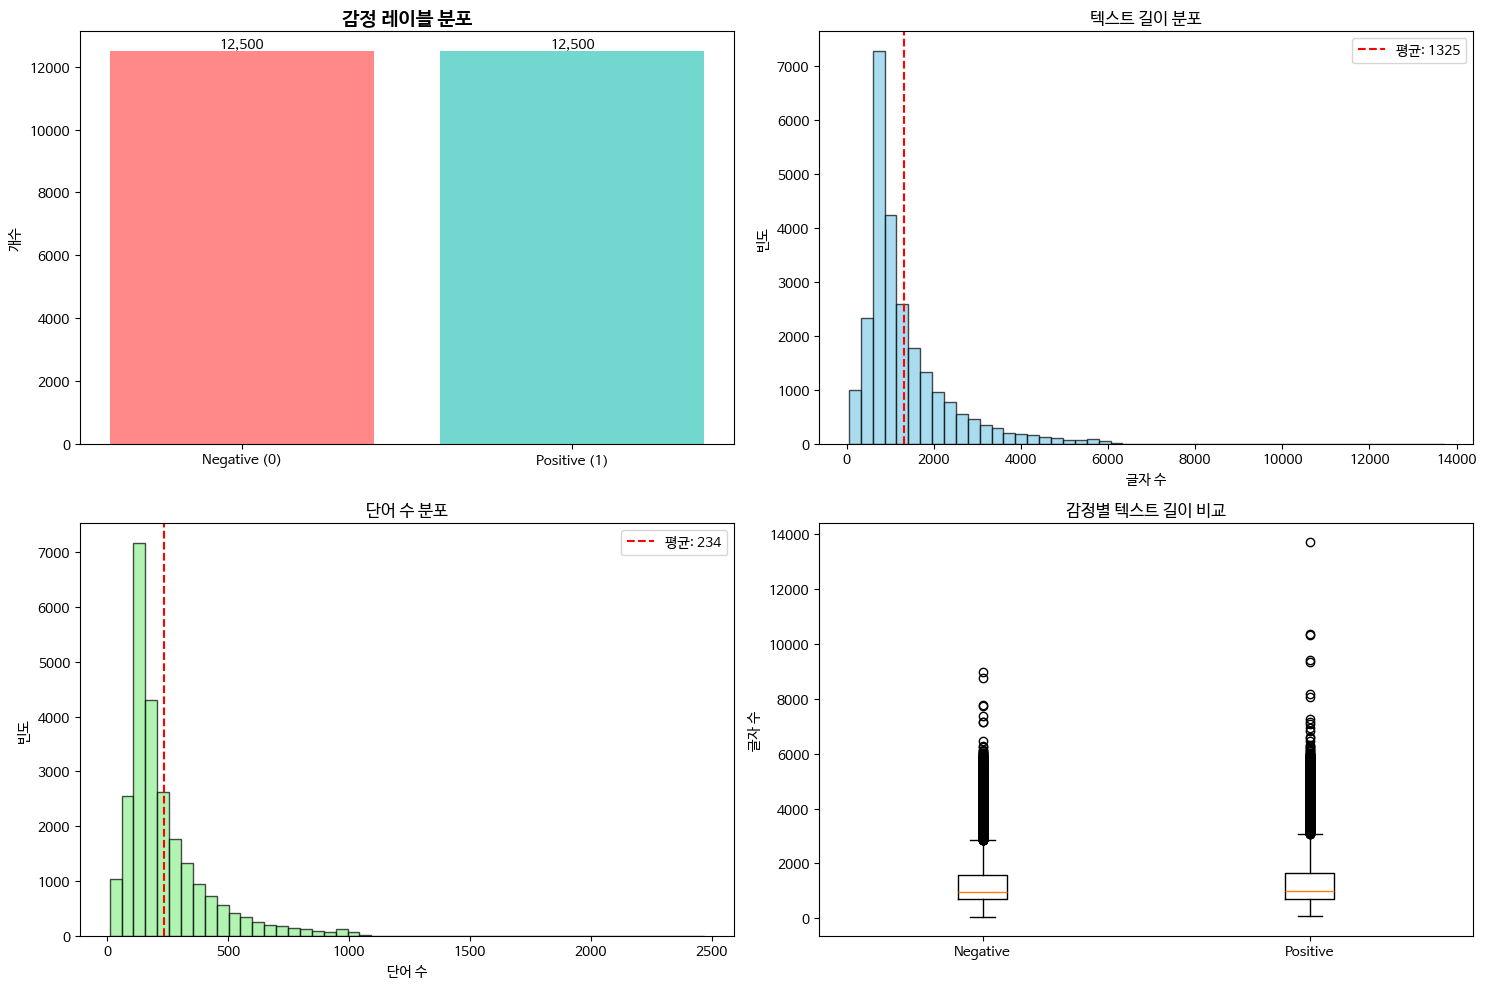

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. 감정 레이블 분포
label_counts = train_df['label'].value_counts().sort_index()
bars1 = axes[0, 0].bar(['Negative (0)', 'Positive (1)'], label_counts.values,
                        color=['#ff6b6b', '#4ecdc4'], alpha=0.8)
axes[0, 0].set_title('감정 레이블 분포', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('개수')

# 막대에 수치 표시
for bar in bars1:
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height):,}', ha='center', va='bottom')

# 2. 텍스트 길이 분포
axes[0, 1].hist(train_df['text_length'], bins=50, alpha=0.7, color='skyblue',
                edgecolor='black')
axes[0, 1].set_title('텍스트 길이 분포')
axes[0, 1].set_xlabel('글자 수')
axes[0, 1].set_ylabel('빈도')
axes[0, 1].axvline(train_df['text_length'].mean(), color='red', linestyle='--',
                    label=f'평균: {train_df["text_length"].mean():.0f}')
axes[0, 1].legend()

# 3. 단어 수 분포
axes[1, 0].hist(train_df['word_count'], bins=50, alpha=0.7, color='lightgreen',
                edgecolor='black')
axes[1, 0].set_title('단어 수 분포')
axes[1, 0].set_xlabel('단어 수')
axes[1, 0].set_ylabel('빈도')
axes[1, 0].axvline(train_df['word_count'].mean(), color='red', linestyle='--',
                    label=f'평균: {train_df["word_count"].mean():.0f}')
axes[1, 0].legend()

# 4. 감정별 평균 길이 비교
pos_lengths = train_df[train_df['label'] == 1]['text_length']
neg_lengths = train_df[train_df['label'] == 0]['text_length']

axes[1, 1].boxplot([neg_lengths, pos_lengths],
                    labels=['Negative', 'Positive'])
axes[1, 1].set_title('감정별 텍스트 길이 비교')
axes[1, 1].set_ylabel('글자 수')

plt.tight_layout()
plt.show()

빈도가 높은 단어 15개 출력

In [15]:
# 전체 단어 추출
top_n=15

all_words = []
for text in train_df['text']:
    words = text.lower().split()
    all_words.extend(words)

# 단어 빈도 계산
word_freq = Counter(all_words)
total_words = len(all_words)
unique_words = len(word_freq)

print(f"📈 전체 통계:")
print(f"   총 단어 수: {total_words:,}개")
print(f"   고유 단어 수: {unique_words:,}개")
print(f"   어휘 다양성: {unique_words/total_words:.4f}")

print(f"\n🔤 가장 빈번한 단어 Top {top_n}:")
for i, (word, freq) in enumerate(word_freq.most_common(top_n), 1):
    percentage = freq / total_words * 100
    print(f"   {i:2d}. {word:15s}: {freq:6,}회 ({percentage:.2f}%)")

📈 전체 통계:
   총 단어 수: 5,844,680개
   고유 단어 수: 251,637개
   어휘 다양성: 0.0431

🔤 가장 빈번한 단어 Top 15:
    1. the            : 322,198회 (5.51%)
    2. a              : 159,953회 (2.74%)
    3. and            : 158,572회 (2.71%)
    4. of             : 144,462회 (2.47%)
    5. to             : 133,967회 (2.29%)
    6. is             : 104,171회 (1.78%)
    7. in             : 90,527회 (1.55%)
    8. i              : 70,480회 (1.21%)
    9. this           : 69,714회 (1.19%)
   10. that           : 66,292회 (1.13%)
   11. it             : 65,505회 (1.12%)
   12. /><br          : 50,935회 (0.87%)
   13. was            : 47,024회 (0.80%)
   14. as             : 45,102회 (0.77%)
   15. for            : 42,843회 (0.73%)


/><br가 꽤 빈번하게 나오는 것을 확인했다.

html 마크업 문법이거나 문장 사이 구분자 같다.   
※ 특정 문자가 있는 문장만 출력하는 구문이 있으면 좋을 것 같다.

# 결측값, 중복값, 공백, 극단값 확인

In [16]:
pd.set_option('display.max_colwidth', None)  # 칼럼 폭 제한 없음
find_br = train_df[train_df['text'].str.contains('/><br')]

In [17]:
find_br['text'].head(2)

,text
0,"I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered ""controversial"" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, even then it's not shot like some cheaply made porno. While my countrymen mind find it shocking, in reality sex and nudity are a major staple in Swedish cinema. Even Ingmar Bergman, arguably their answer to good old boy John Ford, had sex scenes in his films.<br /><br />I do commend the filmmakers for the fact that any sex shown in the film is shown for artistic purposes rather than just to shock people and make money to be shown in pornographic theaters in America. I AM CURIOUS-YELLOW is a good film for anyone wanting to study the meat and potatoes (no pun intended) of Swedish cinema. But really, this film doesn't have much of a plot."
2,"If only to avoid making this type of film in the future. This film is interesting as an experiment but tells no cogent story.<br /><br />One might feel virtuous for sitting thru it because it touches on so many IMPORTANT issues but it does so without any discernable motive. The viewer comes away with no new perspectives (unless one comes up with one while one's mind wanders, as it will invariably do during this pointless film).<br /><br />One might better spend one's time staring out a window at a tree growing.<br /><br />"


In [18]:
print(find_br['text'].head(1))

0    I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between

문장이 여러개가 있는 것을 확인했다.

In [19]:
# 결측값 확인
missing_text = train_df['text'].isnull().sum()
missing_label = train_df['label'].isnull().sum()
print(f"📋 결측값:")
print(f"   텍스트: {missing_text}개")
print(f"   레이블: {missing_label}개")

📋 결측값:
   텍스트: 0개
   레이블: 0개


In [20]:
# 빈 텍스트 확인
empty_text = (train_df['text'].str.strip() == '').sum()
print(f"   빈 텍스트: {empty_text}개")

   빈 텍스트: 0개


In [21]:
# 중복 확인
duplicates = train_df.duplicated().sum()
print(f"   중복 데이터: {duplicates}개")

   중복 데이터: 96개


In [22]:
# 극단적으로 짧거나 긴 텍스트
very_short = (train_df['text_length'] < 50).sum()
very_long = (train_df['text_length'] > 5000).sum()
print(f"   매우 짧은 텍스트 (<50자): {very_short}개")
print(f"   매우 긴 텍스트 (>5000자): {very_long}개")

if missing_text == 0 and missing_label == 0 and empty_text == 0:
    print("   ✅ 데이터 품질 양호!")
else:
    print("   ⚠️ 데이터 전처리 필요")

   매우 짧은 텍스트 (<50자): 0개
   매우 긴 텍스트 (>5000자): 313개
   ✅ 데이터 품질 양호!


## 현재까지 파악한 것

1. 문장의 길이가 상당하다.
2. /><br가 있어 불용어 처리가 필요하다.

# 데이터 전처리 및 토큰화

## 데이터 전처리

In [23]:
import re
import string
# NLTK 라이브러리
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

In [24]:
# NLTK 데이터 다운로드 (최초 한 번만)
def download_nltk_data():
    """NLTK 필요 데이터 다운로드"""
    nltk_data = ['punkt', 'stopwords', 'wordnet', 'averaged_perceptron_tagger', 'punkt_tab']

    for data in nltk_data:
        try:
            nltk.data.find(f'tokenizers/{data}' if data == 'punkt' or data == 'punkt_tab' else
                          f'corpora/{data}' if data in ['stopwords', 'wordnet'] else
                          f'taggers/{data}')
        except LookupError:
            print(f"📥 NLTK {data} 다운로드 중...")
            nltk.download(data, quiet=True)
    print("✅ 다운로드 완료!")

In [25]:
# NLTK 데이터 다운로드
download_nltk_data()

📥 NLTK wordnet 다운로드 중...
✅ 다운로드 완료!


In [26]:
class IMDBPreprocessor:
    """IMDB 데이터 전용 전처리 클래스"""

    def __init__(self):
        # 도구 초기화
        self.stemmer = PorterStemmer()
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))

        # IMDB 특화 불용어 추가
        self.custom_stopwords = {
            'movie', 'film', 'movies', 'films', 'cinema', 'watch', 'watching',
            'watched', 'see', 'seen', 'show', 'series', 'episode', 'character',
            'characters', 'story', 'plot', 'scene', 'scenes', 'director',
            'actor', 'actress', 'acting', 'performance', 'cast', 'script',
            'one', 'two', 'would', 'could', 'should', 'also', 'get', 'go',
            'time', 'even', 'really', 'much', 'well', 'way', 'make', 'made',
            'take', 'year', 'years', 'end', 'first', 'last', 'good', 'bad'
        }
        self.stop_words.update(self.custom_stopwords)

        # 축약형 사전
        self.contractions = {
            "don't": "do not", "won't": "will not", "can't": "cannot",
            "n't": " not", "'re": " are", "'ve": " have", "'ll": " will",
            "'d": " would", "'m": " am", "it's": "it is", "that's": "that is",
            "there's": "there is", "here's": "here is", "what's": "what is",
            "where's": "where is", "who's": "who is", "how's": "how is",
            "let's": "let us", "i'm": "i am", "you're": "you are",
            "we're": "we are", "they're": "they are", "i've": "i have",
            "you've": "you have", "we've": "we have", "they've": "they have",
            "i'll": "i will", "you'll": "you will", "we'll": "we will",
            "they'll": "they will", "i'd": "i would", "you'd": "you would",
            "we'd": "we would", "they'd": "they would"
        }

    def clean_html(self, text):
        """HTML 태그 제거"""
        # IMDB 데이터에 특히 많은 <br /> 태그 제거
        text = re.sub(r'<br\s*/?>', ' ', text, flags=re.IGNORECASE)
        # 기타 HTML 태그 제거
        text = re.sub(r'<[^>]+>', '', text)
        return text

    def clean_urls_emails(self, text):
        """URL과 이메일 제거"""
        # URL 제거
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        # 이메일 제거
        text = re.sub(r'\S+@\S+', '', text)
        return text

    def expand_contractions(self, text):
        """축약형 확장"""
        for contraction, expansion in self.contractions.items():
            text = text.replace(contraction, expansion)
        return text

    def clean_text(self, text):
        """기본 텍스트 정제"""
        if not isinstance(text, str):
            return ""

        # 1. HTML 태그 제거
        text = self.clean_html(text)

        # 2. URL, 이메일 제거
        text = self.clean_urls_emails(text)

        # 3. 소문자 변환
        text = text.lower()

        # 4. 축약형 확장
        text = self.expand_contractions(text)

        # 5. 숫자 제거 (선택적 - 평점 등이 중요할 수 있음)
        # text = re.sub(r'\d+', '', text)

        # 6. 특수문자 제거 (문자와 공백만 남김)
        text = re.sub(r'[^a-zA-Z\s]', ' ', text)

        # 7. 연속된 공백을 하나로
        text = re.sub(r'\s+', ' ', text)

        # 8. 양쪽 공백 제거
        text = text.strip()

        return text

    def tokenize_and_filter(self, text):
        """토큰화 및 필터링"""
        # 토큰화: 단어 토큰화
        tokens = word_tokenize(text)

        # 구두점 제거
        tokens = [token for token in tokens if token not in string.punctuation]

        # 길이가 2 이상인 토큰만 선택
        tokens = [token for token in tokens if len(token) >= 2]

        # 불용어 제거
        tokens = [token for token in tokens if token.lower() not in self.stop_words]

        return tokens

    def lemmatize_tokens(self, tokens):
        """표제어 추출"""
        return [self.lemmatizer.lemmatize(token) for token in tokens]

    def stem_tokens(self, tokens):
        """어간 추출"""
        return [self.stemmer.stem(token) for token in tokens]

    def preprocess_text(self, text, use_lemmatization=True, use_stemming=False):
        """전체 전처리 파이프라인"""
        # 1. 텍스트 정제
        cleaned_text = self.clean_text(text)

        # 2. 토큰화 및 필터링
        tokens = self.tokenize_and_filter(cleaned_text)

        # 3. 표제어 추출 또는 어간 추출
        if use_lemmatization:
            tokens = self.lemmatize_tokens(tokens)
        elif use_stemming:
            tokens = self.stem_tokens(tokens)

        return tokens

    def process_dataframe(self, df, text_column='text'):
        """DataFrame 전처리"""
        print(f"📊 {len(df)}개 텍스트 전처리 중...")

        # 1. 원본 텍스트 정제
        print("   1단계: 텍스트 정제...")
        df['cleaned_text'] = df[text_column].apply(self.clean_text)

        # 2. 토큰화
        print("   2단계: 토큰화 및 표제어 추출...")
        df['tokens'] = df['cleaned_text'].apply(
            lambda x: self.preprocess_text(x, use_lemmatization=True)
        )

        # 3. 토큰을 문자열로 결합 (나중에 벡터화할 때 사용)
        df['processed_text'] = df['tokens'].apply(lambda x: ' '.join(x))

        # 4. 통계 계산
        df['token_count'] = df['tokens'].apply(len)
        df['processed_length'] = df['processed_text'].str.len()

        print(f"   ✅ 전처리 완료!")
        return df

In [27]:
# Step 1에서 로드한 데이터 확인
try:
    train_df = train_df.copy()  # Step 1에서 저장된 변수 사용
    test_df = test_df.copy()
    print(f"✅ Step 1 데이터 로드 완료")
    print(f"   훈련 데이터: {len(train_df):,}개")
    print(f"   테스트 데이터: {len(test_df):,}개")
except NameError:
    print("❌ Step 1을 먼저 실행하여 데이터를 로드하세요.")

✅ Step 1 데이터 로드 완료
   훈련 데이터: 25,000개
   테스트 데이터: 25,000개


In [28]:
# 전처리기 초기화
preprocessor = IMDBPreprocessor()

In [29]:
# 훈련 데이터 전처리
train_processed = preprocessor.process_dataframe(train_df)
test_processed = preprocessor.process_dataframe(test_df)

📊 25000개 텍스트 전처리 중...
   1단계: 텍스트 정제...
   2단계: 토큰화 및 표제어 추출...
   ✅ 전처리 완료!
📊 25000개 텍스트 전처리 중...
   1단계: 텍스트 정제...
   2단계: 토큰화 및 표제어 추출...
   ✅ 전처리 완료!


In [30]:
def analyze_preprocessing_results(original_df, processed_df):
    """전처리 결과 분석"""
    print(f"\n📊 전처리 결과 분석")
    print("=" * 40)

    # 기본 통계
    original_avg_length = original_df['text'].str.len().mean()
    processed_avg_length = processed_df['processed_length'].mean()
    original_avg_words = original_df['text'].str.split().str.len().mean()
    processed_avg_tokens = processed_df['token_count'].mean()

    print(f"📏 길이 변화:")
    print(f"   원본 평균 글자 수: {original_avg_length:.0f}")
    print(f"   처리 후 평균 글자 수: {processed_avg_length:.0f}")
    print(f"   글자 수 감소율: {(1 - processed_avg_length/original_avg_length)*100:.1f}%")

    print(f"\n🔤 토큰 변화:")
    print(f"   원본 평균 단어 수: {original_avg_words:.0f}")
    print(f"   처리 후 평균 토큰 수: {processed_avg_tokens:.0f}")
    print(f"   토큰 수 감소율: {(1 - processed_avg_tokens/original_avg_words)*100:.1f}%")

    # 시각화
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. 전처리 전후 길이 비교
    axes[0, 0].hist(original_df['text'].str.len(), bins=50, alpha=0.7,
                   label='전처리 전', color='red')
    axes[0, 0].hist(processed_df['processed_length'], bins=50, alpha=0.7,
                   label='전처리 후', color='blue')
    axes[0, 0].set_title('텍스트 길이 비교')
    axes[0, 0].set_xlabel('글자 수')
    axes[0, 0].set_ylabel('빈도')
    axes[0, 0].legend()

    # 2. 토큰 수 분포
    axes[0, 1].hist(processed_df['token_count'], bins=50, alpha=0.7, color='green')
    axes[0, 1].set_title('전처리 후 토큰 수 분포')
    axes[0, 1].set_xlabel('토큰 수')
    axes[0, 1].set_ylabel('빈도')
    axes[0, 1].axvline(processed_df['token_count'].mean(), color='red',
                      linestyle='--', label=f'평균: {processed_df["token_count"].mean():.0f}')
    axes[0, 1].legend()

    # 3. 감정별 토큰 수 비교
    pos_tokens = processed_df[processed_df['label'] == 1]['token_count']
    neg_tokens = processed_df[processed_df['label'] == 0]['token_count']

    axes[1, 0].boxplot([neg_tokens, pos_tokens],
                      labels=['Negative', 'Positive'])
    axes[1, 0].set_title('감정별 토큰 수 비교')
    axes[1, 0].set_ylabel('토큰 수')

    # 4. 전처리 효과 (길이 감소율 분포)
    length_reduction = (1 - processed_df['processed_length'] /
                       original_df['text'].str.len()) * 100

    axes[1, 1].hist(length_reduction, bins=50, alpha=0.7, color='orange')
    axes[1, 1].set_title('길이 감소율 분포')
    axes[1, 1].set_xlabel('감소율 (%)')
    axes[1, 1].set_ylabel('빈도')
    axes[1, 1].axvline(length_reduction.mean(), color='red',
                      linestyle='--', label=f'평균: {length_reduction.mean():.1f}%')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

In [31]:
def show_preprocessing_examples(original_df, processed_df, n_examples=3):
    """전처리 전후 비교 예시"""
    print(f"\n📝 전처리 전후 비교 예시")
    print("=" * 60)

    for i in range(n_examples):
        original_text = original_df.iloc[i]['text']
        processed_text = processed_df.iloc[i]['processed_text']
        tokens = processed_df.iloc[i]['tokens']

        print(f"\n📄 예시 {i+1}:")
        print(f"🔸 원본 (길이: {len(original_text)}자):")
        print(f"   {original_text[:200]}...")

        print(f"🔹 전처리 후 (길이: {len(processed_text)}자, 토큰: {len(tokens)}개):")
        print(f"   {processed_text[:200]}...")

        print(f"🔸 토큰 (첫 15개):")
        print(f"   {tokens[:15]}")

In [32]:
def analyze_vocabulary_changes(original_df, processed_df):
    """어휘 변화 분석"""
    print(f"\n📚 어휘 변화 분석")
    print("=" * 40)

    # 원본 어휘
    original_words = []
    for text in original_df['text']:
        words = text.lower().split()
        original_words.extend(words)

    # 전처리 후 어휘
    processed_words = []
    for tokens in processed_df['tokens']:
        processed_words.extend(tokens)

    original_vocab = set(original_words)
    processed_vocab = set(processed_words)

    print(f"📊 어휘 통계:")
    print(f"   전처리 전 고유 단어 수: {len(original_vocab):,}개")
    print(f"   전처리 후 고유 단어 수: {len(processed_vocab):,}개")
    print(f"   어휘 감소율: {(1 - len(processed_vocab)/len(original_vocab))*100:.1f}%")

    # 빈도 분석
    original_freq = Counter(original_words)
    processed_freq = Counter(processed_words)

    print(f"\n🔤 가장 빈번한 단어 비교 (Top 10):")
    print(f"{'전처리 전':<20} {'전처리 후':<20}")
    print("-" * 42)

    original_top = original_freq.most_common(10)
    processed_top = processed_freq.most_common(10)

    for i in range(10):
        orig_word, orig_freq = original_top[i]
        proc_word, proc_freq = processed_top[i]
        print(f"{orig_word:<15} {orig_freq:>4,}   {proc_word:<15} {proc_freq:>4,}")


📊 전처리 결과 분석
📏 길이 변화:
   원본 평균 글자 수: 1325
   처리 후 평균 글자 수: 716
   글자 수 감소율: 45.9%

🔤 토큰 변화:
   원본 평균 단어 수: 234
   처리 후 평균 토큰 수: 102
   토큰 수 감소율: 56.3%


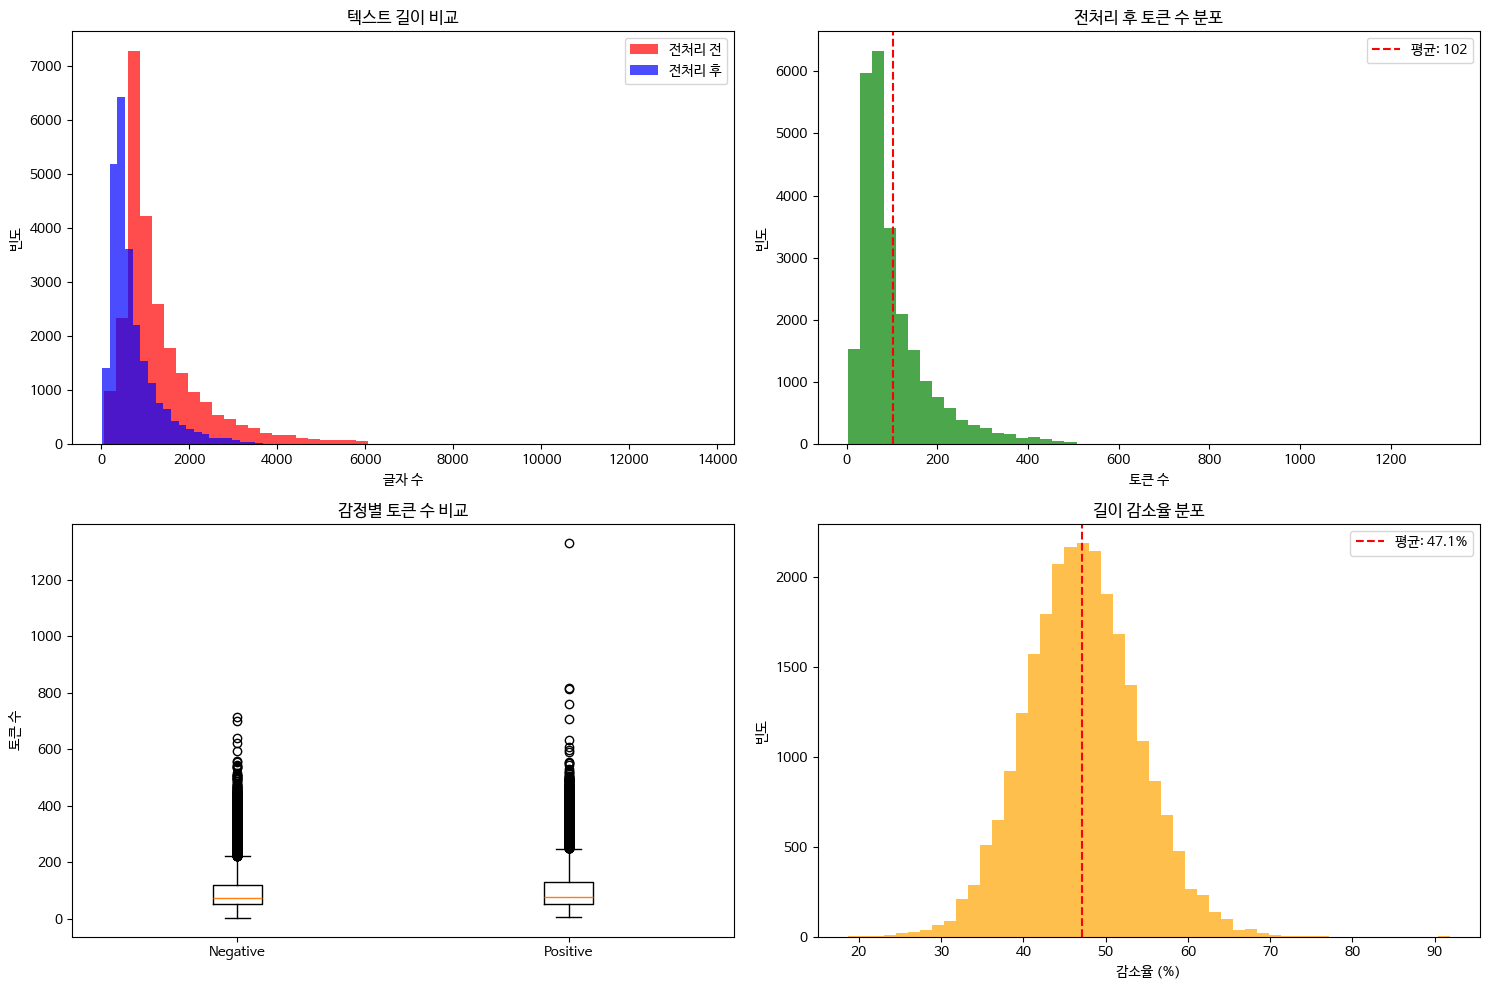


📝 전처리 전후 비교 예시

📄 예시 1:
🔸 원본 (길이: 1640자):
   I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ev...
🔹 전처리 후 (길이: 867자, 토큰: 121개):
   rented curious yellow video store controversy surrounded released heard seized custom ever tried enter country therefore fan considered controversial centered around young swedish drama student named ...
🔸 토큰 (첫 15개):
   ['rented', 'curious', 'yellow', 'video', 'store', 'controversy', 'surrounded', 'released', 'heard', 'seized', 'custom', 'ever', 'tried', 'enter', 'country']

📄 예시 2:
🔸 원본 (길이: 1294자):
   "I Am Curious: Yellow" is a risible and pretentious steaming pile. It doesn't matter what one's political views are because this film can hardly be taken seriously on any level. As for the claim that ...
🔹 전처리 후 (길이: 769자, 토큰: 106개):
   curious yellow risible pretentious steaming pile matter political view h

In [33]:
# 결과 분석
analyze_preprocessing_results(train_df, train_processed)

# 예시 확인
show_preprocessing_examples(train_df, train_processed)

# 어휘 변화 분석
analyze_vocabulary_changes(train_df, train_processed)

관용어들 제거를 통해 빈번한 단어 순위가 많이 바뀌었다.

html 문법도 제거와 문장 길이 조정을 통해 질좋은 데이터가 되었다.


In [34]:
# 전역 변수로 저장
globals()['imdb_train_processed'] = train_processed
globals()['imdb_test_processed'] = test_processed

# 모델링

## 머신러닝

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           classification_report, confusion_matrix, roc_auc_score, roc_curve)
import time

### 임베딩(TF-IDF, Count)

In [36]:
print("🚀 IMDB 감정분석 - 나이브베이즈 vs 로지스틱회귀")
print("=" * 60)

🚀 IMDB 감정분석 - 나이브베이즈 vs 로지스틱회귀


In [37]:
# Step 2에서 전처리된 데이터 확인
try:
    train_df = train_processed.copy()
    test_df = test_processed.copy()
    print(f"✅ 전처리된 데이터 로드 완료")
    print(f"   훈련 데이터: {len(train_df):,}개")
    print(f"   테스트 데이터: {len(test_df):,}개")

    # 빈 텍스트 제거
    train_df = train_df[train_df['processed_text'].str.strip() != '']
    test_df = test_df[test_df['processed_text'].str.strip() != '']

    print(f"✅ 정제 후 데이터:")
    print(f"   훈련 데이터: {len(train_df):,}개")
    print(f"   테스트 데이터: {len(test_df):,}개")

except NameError:
    print("❌ Step 2를 먼저 실행하여 전처리된 데이터를 준비하세요.")

✅ 전처리된 데이터 로드 완료
   훈련 데이터: 25,000개
   테스트 데이터: 25,000개
✅ 정제 후 데이터:
   훈련 데이터: 25,000개
   테스트 데이터: 25,000개


In [38]:
print("\n📊 TF-IDF 특성 추출")
print("=" * 40)

# TF-IDF 벡터라이저 설정
vectorizer = TfidfVectorizer(
    max_features=10000,          # 최대 10,000개 특성
    ngram_range=(1, 2),          # 1-gram과 2-gram 사용
    min_df=2,                    # 최소 2번 이상 나타난 단어
    max_df=0.8,                  # 전체 문서의 80% 이하에서 나타난 단어
    sublinear_tf=True,           # 로그 스케일링
    stop_words='english'         # 영어 불용어 제거
)

print("🔧 TF-IDF 설정:")
print(f"   최대 특성 수: 10,000")
print(f"   N-gram 범위: (1, 2)")
print(f"   최소 문서 빈도: 2")
print(f"   최대 문서 빈도: 0.8")

# 벡터화 실행
print("\n🔄 벡터화 중...")
start_time = time.time()

X_train = vectorizer.fit_transform(train_df['processed_text'])
X_test = vectorizer.transform(test_df['processed_text'])
y_train = train_df['label'].values
y_test = test_df['label'].values

vectorization_time = time.time() - start_time

print(f"✅ 벡터화 완료! ({vectorization_time:.2f}초)")
print(f"   훈련 데이터 크기: {X_train.shape}")
print(f"   테스트 데이터 크기: {X_test.shape}")
print(f"   실제 특성 수: {X_train.shape[1]:,}")
print(f"   희소성: {(1.0 - X_train.nnz / (X_train.shape[0] * X_train.shape[1])) * 100:.1f}%")


📊 TF-IDF 특성 추출
🔧 TF-IDF 설정:
   최대 특성 수: 10,000
   N-gram 범위: (1, 2)
   최소 문서 빈도: 2
   최대 문서 빈도: 0.8

🔄 벡터화 중...
✅ 벡터화 완료! (13.19초)
   훈련 데이터 크기: (25000, 10000)
   테스트 데이터 크기: (25000, 10000)
   실제 특성 수: 10,000
   희소성: 99.3%


### 모델 학습 및 평가

In [39]:
print("\n🎯 나이브 베이즈 모델 학습")
print("=" * 40)

# 하이퍼파라미터 그리드
nb_param_grid = {
    'alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0]
}

print("🔍 그리드 서치로 최적 파라미터 찾는 중...")
start_time = time.time()

# 그리드 서치
nb_grid = GridSearchCV(
    MultinomialNB(),
    nb_param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=0
)

nb_grid.fit(X_train, y_train)
nb_model = nb_grid.best_estimator_

# 예측
nb_pred = nb_model.predict(X_test)
nb_pred_proba = nb_model.predict_proba(X_test)[:, 1]

# 성능 계산
nb_accuracy = accuracy_score(y_test, nb_pred)
nb_precision = precision_score(y_test, nb_pred)
nb_recall = recall_score(y_test, nb_pred)
nb_f1 = f1_score(y_test, nb_pred)
nb_auc = roc_auc_score(y_test, nb_pred_proba)

# 교차검증
nb_cv_scores = cross_val_score(nb_model, X_train, y_train, cv=5, scoring='f1')
nb_training_time = time.time() - start_time

print(f"✅ 나이브 베이즈 학습 완료!")
print(f"   최적 파라미터: {nb_grid.best_params_}")
print(f"   정확도: {nb_accuracy:.4f}")
print(f"   정밀도: {nb_precision:.4f}")
print(f"   재현율: {nb_recall:.4f}")
print(f"   F1 점수: {nb_f1:.4f}")
print(f"   AUC: {nb_auc:.4f}")
print(f"   교차검증: {nb_cv_scores.mean():.4f} (±{nb_cv_scores.std():.4f})")
print(f"   학습 시간: {nb_training_time:.2f}초")


🎯 나이브 베이즈 모델 학습
🔍 그리드 서치로 최적 파라미터 찾는 중...
✅ 나이브 베이즈 학습 완료!
   최적 파라미터: {'alpha': 5.0}
   정확도: 0.8450
   정밀도: 0.8689
   재현율: 0.8125
   F1 점수: 0.8398
   AUC: 0.9250
   교차검증: 0.8270 (±0.0132)
   학습 시간: 4.17초


In [40]:
print("\n🎯 로지스틱 회귀 모델 학습")
print("=" * 40)

# 하이퍼파라미터 그리드
lr_param_grid = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

print("🔍 그리드 서치로 최적 파라미터 찾는 중...")
start_time = time.time()

# 그리드 서치
lr_grid = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=1000),
    lr_param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=0
)

lr_grid.fit(X_train, y_train)
lr_model = lr_grid.best_estimator_

# 예측
lr_pred = lr_model.predict(X_test)
lr_pred_proba = lr_model.predict_proba(X_test)[:, 1]

# 성능 계산
lr_accuracy = accuracy_score(y_test, lr_pred)
lr_precision = precision_score(y_test, lr_pred)
lr_recall = recall_score(y_test, lr_pred)
lr_f1 = f1_score(y_test, lr_pred)
lr_auc = roc_auc_score(y_test, lr_pred_proba)

# 교차검증
lr_cv_scores = cross_val_score(lr_model, X_train, y_train, cv=5, scoring='f1')
lr_training_time = time.time() - start_time

print(f"✅ 로지스틱 회귀 학습 완료!")
print(f"   최적 파라미터: {lr_grid.best_params_}")
print(f"   정확도: {lr_accuracy:.4f}")
print(f"   정밀도: {lr_precision:.4f}")
print(f"   재현율: {lr_recall:.4f}")
print(f"   F1 점수: {lr_f1:.4f}")
print(f"   AUC: {lr_auc:.4f}")
print(f"   교차검증: {lr_cv_scores.mean():.4f} (±{lr_cv_scores.std():.4f})")
print(f"   학습 시간: {lr_training_time:.2f}초")


🎯 로지스틱 회귀 모델 학습
🔍 그리드 서치로 최적 파라미터 찾는 중...
✅ 로지스틱 회귀 학습 완료!
   최적 파라미터: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
   정확도: 0.8787
   정밀도: 0.8773
   재현율: 0.8806
   F1 점수: 0.8789
   AUC: 0.9502
   교차검증: 0.8607 (±0.0048)
   학습 시간: 15.11초


### 모델 성능 비교

In [41]:
print("\n📊 모델 성능 비교")
print("=" * 50)

# 결과 정리
comparison_data = {
    '메트릭': ['정확도', 'F1 점수', 'AUC', '교차검증', '학습시간(초)'],
    '나이브 베이즈': [
        f"{nb_accuracy:.4f}",
        f"{nb_f1:.4f}",
        f"{nb_auc:.4f}",
        f"{nb_cv_scores.mean():.4f}±{nb_cv_scores.std():.3f}",
        f"{nb_training_time:.2f}"
    ],
    '로지스틱 회귀': [
        f"{lr_accuracy:.4f}",
        f"{lr_f1:.4f}",
        f"{lr_auc:.4f}",
        f"{lr_cv_scores.mean():.4f}±{lr_cv_scores.std():.3f}",
        f"{lr_training_time:.2f}"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# 최고 성능 모델 찾기
if nb_f1 > lr_f1:
    best_model_name = "나이브 베이즈"
    best_model = nb_model
    best_f1 = nb_f1
    best_accuracy = nb_accuracy
else:
    best_model_name = "로지스틱 회귀"
    best_model = lr_model
    best_f1 = lr_f1
    best_accuracy = lr_accuracy

print(f"\n🏆 최고 성능 모델: {best_model_name}")
print(f"   F1 점수: {best_f1:.4f}")
print(f"   정확도: {best_accuracy:.4f}")


📊 모델 성능 비교
    메트릭      나이브 베이즈      로지스틱 회귀
    정확도       0.8450       0.8787
  F1 점수       0.8398       0.8789
    AUC       0.9250       0.9502
   교차검증 0.8270±0.013 0.8607±0.005
학습시간(초)         4.17        15.11

🏆 최고 성능 모델: 로지스틱 회귀
   F1 점수: 0.8789
   정확도: 0.8787


### 성능 시각화


📈 성능 시각화


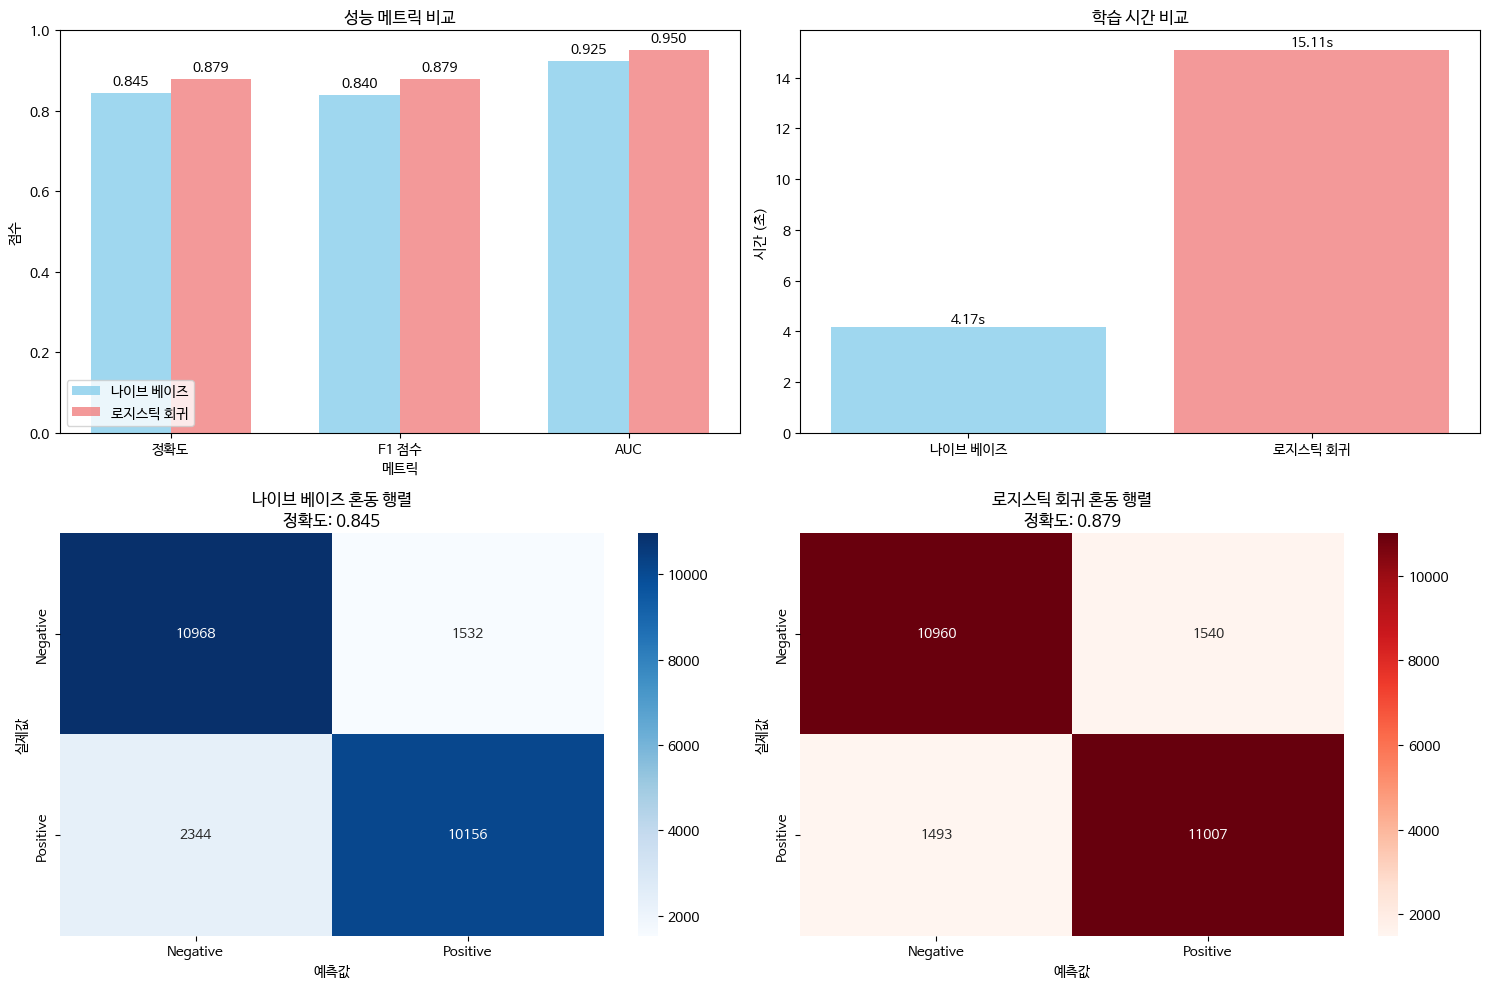

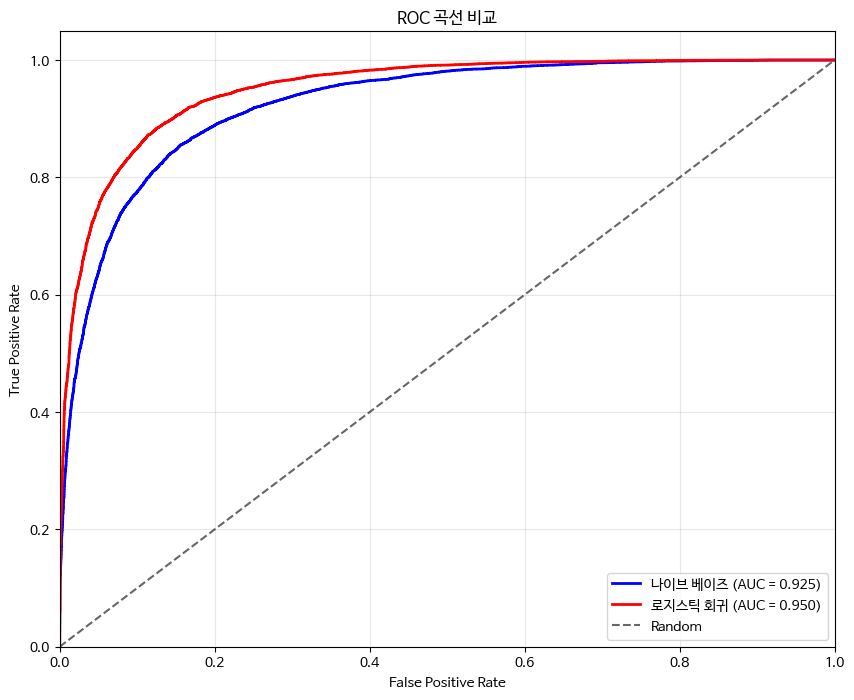

In [42]:
print("\n📈 성능 시각화")
print("=" * 30)

# 1. 성능 메트릭 비교
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 메트릭별 비교
metrics = [nb_accuracy, nb_f1, nb_auc]
lr_metrics = [lr_accuracy, lr_f1, lr_auc]
metric_names = ['정확도', 'F1 점수', 'AUC']
model_names = ['나이브 베이즈', '로지스틱 회귀']

x = np.arange(len(metric_names))
width = 0.35

bars1 = axes[0, 0].bar(x - width/2, metrics, width, label='나이브 베이즈', alpha=0.8, color='skyblue')
bars2 = axes[0, 0].bar(x + width/2, lr_metrics, width, label='로지스틱 회귀', alpha=0.8, color='lightcoral')

axes[0, 0].set_xlabel('메트릭')
axes[0, 0].set_ylabel('점수')
axes[0, 0].set_title('성능 메트릭 비교')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(metric_names)
axes[0, 0].legend()
axes[0, 0].set_ylim(0, 1)

# 값 표시
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{height:.3f}', ha='center', va='bottom')

# 2. 학습 시간 비교
time_comparison = [nb_training_time, lr_training_time]
bars_time = axes[0, 1].bar(model_names, time_comparison, alpha=0.8, color=['skyblue', 'lightcoral'])
axes[0, 1].set_ylabel('시간 (초)')
axes[0, 1].set_title('학습 시간 비교')

for bar in bars_time:
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.2f}s', ha='center', va='bottom')

# 3. 나이브 베이즈 혼동 행렬
nb_cm = confusion_matrix(y_test, nb_pred)
sns.heatmap(nb_cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Negative', 'Positive'],
           yticklabels=['Negative', 'Positive'],
           ax=axes[1, 0])
axes[1, 0].set_title(f'나이브 베이즈 혼동 행렬\n정확도: {nb_accuracy:.3f}')
axes[1, 0].set_xlabel('예측값')
axes[1, 0].set_ylabel('실제값')

# 4. 로지스틱 회귀 혼동 행렬
lr_cm = confusion_matrix(y_test, lr_pred)
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Reds',
           xticklabels=['Negative', 'Positive'],
           yticklabels=['Negative', 'Positive'],
           ax=axes[1, 1])
axes[1, 1].set_title(f'로지스틱 회귀 혼동 행렬\n정확도: {lr_accuracy:.3f}')
axes[1, 1].set_xlabel('예측값')
axes[1, 1].set_ylabel('실제값')

plt.tight_layout()
plt.show()

# ROC 곡선 비교
plt.figure(figsize=(10, 8))

# 나이브 베이즈 ROC
nb_fpr, nb_tpr, _ = roc_curve(y_test, nb_pred_proba)
plt.plot(nb_fpr, nb_tpr, label=f'나이브 베이즈 (AUC = {nb_auc:.3f})', linewidth=2, color='blue')

# 로지스틱 회귀 ROC
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_pred_proba)
plt.plot(lr_fpr, lr_tpr, label=f'로지스틱 회귀 (AUC = {lr_auc:.3f})', linewidth=2, color='red')

plt.plot([0, 1], [0, 1], 'k--', alpha=0.6, label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC 곡선 비교')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

### 특성 중요도 분석(로지스틱)


🔍 특성 중요도 분석 (로지스틱 회귀)
🟢 긍정 예측에 중요한 특성 Top 15:
    1. great               :   6.6409
    2. excellent           :   6.1895
    3. best                :   5.2168
    4. wonderful           :   4.8212
    5. perfect             :   4.7883
    6. favorite            :   4.6509
    7. amazing             :   4.0259
    8. loved               :   3.8081
    9. today               :   3.7473
   10. enjoyed             :   3.5571
   11. love                :   3.5484
   12. fun                 :   3.5377
   13. superb              :   3.3926
   14. brilliant           :   3.3875
   15. fantastic           :   3.1426

🔴 부정 예측에 중요한 특성 Top 15:
    1. worst               :  -9.1355
    2. awful               :  -6.7128
    3. waste               :  -6.4590
    4. boring              :  -5.6337
    5. worse               :  -5.3273
    6. poor                :  -5.2568
    7. terrible            :  -4.9960
    8. horrible            :  -4.6011
    9. poorly              :  -4.5212
   10. unfortuna

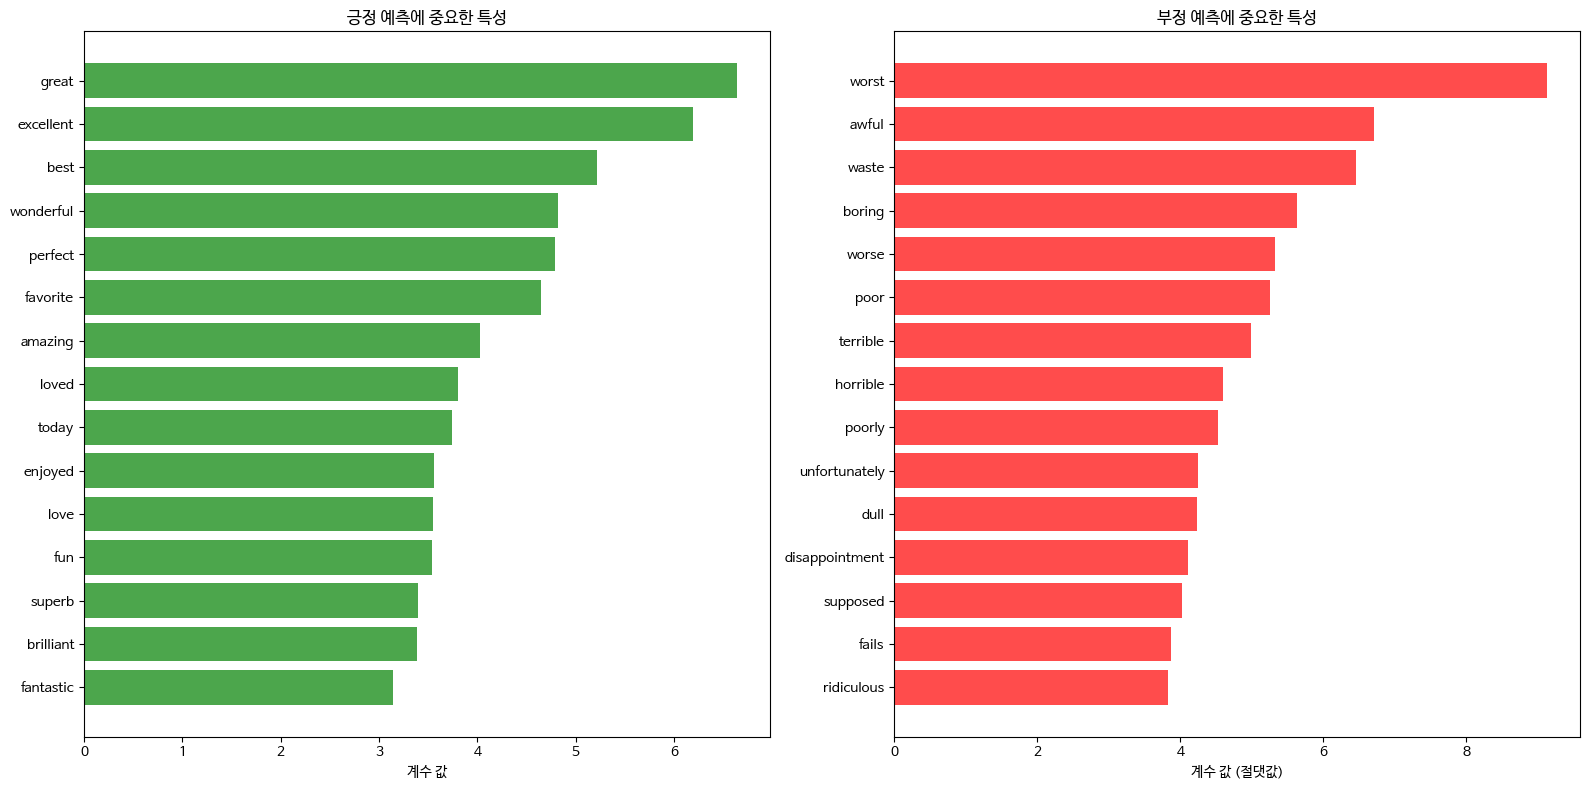

In [43]:
print("\n🔍 특성 중요도 분석 (로지스틱 회귀)")
print("=" * 50)

# 특성 이름 가져오기
feature_names = vectorizer.get_feature_names_out()

# 로지스틱 회귀 계수 분석
lr_coef = lr_model.coef_[0]
feature_importance = list(zip(feature_names, lr_coef))

# 긍정 예측에 중요한 특성 (높은 계수)
positive_features = sorted(feature_importance, key=lambda x: x[1], reverse=True)[:15]

# 부정 예측에 중요한 특성 (낮은 계수)
negative_features = sorted(feature_importance, key=lambda x: x[1])[:15]

print("🟢 긍정 예측에 중요한 특성 Top 15:")
for i, (feature, coef) in enumerate(positive_features, 1):
    print(f"   {i:2d}. {feature:20s}: {coef:8.4f}")

print("\n🔴 부정 예측에 중요한 특성 Top 15:")
for i, (feature, coef) in enumerate(negative_features, 1):
    print(f"   {i:2d}. {feature:20s}: {coef:8.4f}")

# 특성 중요도 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# 긍정적 특성
pos_features, pos_scores = zip(*positive_features)
bars1 = ax1.barh(range(len(pos_features)), pos_scores, color='green', alpha=0.7)
ax1.set_yticks(range(len(pos_features)))
ax1.set_yticklabels(pos_features)
ax1.set_xlabel('계수 값')
ax1.set_title('긍정 예측에 중요한 특성')
ax1.invert_yaxis()

# 부정적 특성
neg_features, neg_scores = zip(*negative_features)
bars2 = ax2.barh(range(len(neg_features)), [abs(s) for s in neg_scores], color='red', alpha=0.7)
ax2.set_yticks(range(len(neg_features)))
ax2.set_yticklabels(neg_features)
ax2.set_xlabel('계수 값 (절댓값)')
ax2.set_title('부정 예측에 중요한 특성')
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

### 실제 예측

In [44]:
print("\n🧪 실제 예측 테스트")
print("=" * 40)

# 테스트할 샘플 텍스트들
sample_texts = [
    "This movie is absolutely fantastic! Great acting and amazing story. Highly recommend!",
    "Terrible film. Complete waste of time and money. Very disappointed with everything.",
    "It was okay, not great but not terrible either. Average movie with decent acting.",
    "One of the best movies I've ever seen! Brilliant direction and outstanding performances!",
    "Boring and predictable plot. Poor character development. Not worth watching."
]

print(f"📝 {best_model_name} 모델로 예측:")

for i, text in enumerate(sample_texts, 1):
    # 벡터화
    X_sample = vectorizer.transform([text])

    # 예측
    prediction = best_model.predict(X_sample)[0]
    probability = best_model.predict_proba(X_sample)[0]

    sentiment = "😊 Positive" if prediction == 1 else "😞 Negative"
    confidence = max(probability)

    print(f"\n테스트 {i}:")
    print(f"   텍스트: {text}")
    print(f"   예측: {sentiment}")
    print(f"   신뢰도: {confidence:.3f}")


🧪 실제 예측 테스트
📝 로지스틱 회귀 모델로 예측:

테스트 1:
   텍스트: This movie is absolutely fantastic! Great acting and amazing story. Highly recommend!
   예측: 😊 Positive
   신뢰도: 0.997

테스트 2:
   텍스트: Terrible film. Complete waste of time and money. Very disappointed with everything.
   예측: 😞 Negative
   신뢰도: 0.997

테스트 3:
   텍스트: It was okay, not great but not terrible either. Average movie with decent acting.
   예측: 😞 Negative
   신뢰도: 0.928

테스트 4:
   텍스트: One of the best movies I've ever seen! Brilliant direction and outstanding performances!
   예측: 😊 Positive
   신뢰도: 0.984

테스트 5:
   텍스트: Boring and predictable plot. Poor character development. Not worth watching.
   예측: 😞 Negative
   신뢰도: 0.996


### 결과

In [45]:
print(f"\n🎉 IMDB 감정분석 완료!")
print("=" * 50)
print(f"✅ TF-IDF 벡터화 완료 ({X_train.shape[1]:,}개 특성)")
print(f"✅ 나이브 베이즈 학습 완료 (F1: {nb_f1:.4f})")
print(f"✅ 로지스틱 회귀 학습 완료 (F1: {lr_f1:.4f})")
print(f"✅ 최고 성능 모델: {best_model_name}")
print(f"✅ 특성 중요도 분석 완료")
print(f"✅ 실제 예측 테스트 완료")

print(f"\n📊 최종 성능:")
print(f"   정확도: {best_accuracy:.4f}")
print(f"   F1 점수: {best_f1:.4f}")

print(f"\n🎯 학습된 내용:")
print("   1. 텍스트 전처리 (정제, 토큰화, 불용어 제거)")
print("   2. TF-IDF 특성 추출 (텍스트 → 숫자 벡터)")
print("   3. 머신러닝 모델 학습 (나이브베이즈, 로지스틱회귀)")
print("   4. 모델 평가 및 비교")
print("   5. 특성 중요도 분석")
print("   6. 실제 예측 및 활용")

print(f"\n🚀 다음 단계 제안:")
print("   - 딥러닝 모델 (LSTM, CNN) 시도")
print("   - 앙상블 방법 적용")
print("   - 하이퍼파라미터 세부 튜닝")
print("   - 다른 데이터셋으로 실험")


🎉 IMDB 감정분석 완료!
✅ TF-IDF 벡터화 완료 (10,000개 특성)
✅ 나이브 베이즈 학습 완료 (F1: 0.8398)
✅ 로지스틱 회귀 학습 완료 (F1: 0.8789)
✅ 최고 성능 모델: 로지스틱 회귀
✅ 특성 중요도 분석 완료
✅ 실제 예측 테스트 완료

📊 최종 성능:
   정확도: 0.8787
   F1 점수: 0.8789

🎯 학습된 내용:
   1. 텍스트 전처리 (정제, 토큰화, 불용어 제거)
   2. TF-IDF 특성 추출 (텍스트 → 숫자 벡터)
   3. 머신러닝 모델 학습 (나이브베이즈, 로지스틱회귀)
   4. 모델 평가 및 비교
   5. 특성 중요도 분석
   6. 실제 예측 및 활용

🚀 다음 단계 제안:
   - 딥러닝 모델 (LSTM, CNN) 시도
   - 앙상블 방법 적용
   - 하이퍼파라미터 세부 튜닝
   - 다른 데이터셋으로 실험
